## Import Library yang akan digunakan

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [2]:
!pip install sastrawi wordcloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 17.2 MB/s eta 0:00:00


In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Data Cleaning

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/haikal-here/gplay_comment_nlp/refs/heads/main/Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Date  12000 non-null  object
 1   Ratings      12000 non-null  int64 
 2   Comment      11999 non-null  object
dtypes: int64(1), object(2)
memory usage: 281.4+ KB


In [5]:
# Duplikat value
data.duplicated().value_counts()

,count
False,12000


In [6]:
# Null Value
data.isna().sum()

,0
Review Date,0
Ratings,0
Comment,1


In [7]:
data = data.dropna()

## Pre-Processing Text

### Cleaning Text

In [8]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = text.replace('\n', ' ')
    text = text.strip()
    return text

In [9]:
data["Text Cleaned"] = data["Comment"].apply(cleaningText)
data

,Review Date,Ratings,Comment,Text Cleaned
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru kali ini kecewa sekali dengan aplik...
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo g jelas mau pinjam di persulit
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah pros...
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet kayak kuntuL
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah
...,...,...,...,...
11995,2025-04-29 22:41:01,5,sagat puas,sagat puas
11996,2025-04-29 22:39:57,5,mantaf,mantaf
11997,2025-04-29 22:36:00,5,bagus sangat membantu,bagus sangat membantu
11998,2025-04-29 22:30:54,5,mantaf,mantaf


#### Text Slang

In [10]:
text_slang = {
    'gue' : 'saya', 'gw' : 'saya', 'gua' : 'saya', 'ak' : 'saya', 'aq' : 'saya', 'gak' : 'tidak', 'gk' : 'tidak', 'ga' : 'tidak', 'g' : 'tidak', 'cpek' : 'lelah','cpk' : 'lelah','capk' : 'lelah','gini' : 'ini','kek' : "seperti",'kayak' : 'seperti','kyk' : 'seperti','kyknya' : 'sepertinya','kayaknya' : 'sepertinya','udh' : 'sudah','dhlh' : 'sudahlah','sdh' : 'sudah','dh' : 'sudah','yg' : 'yang','yng' : 'yang','pdhl' : 'padahal','kikir' : 'pelit','bgt' : 'banget','masi' : 'masih', 'gitu' : 'begitu','gtu' : 'begitu','gt' : 'begitu','mw' : 'mau','smuanya' : 'semuanya','smua' : 'semua','bosenin' : 'membosankan','ngebosenin' : 'membosankan','gtau' : 'tidak tahu','gatau' : 'tidak tahu','gaada' : 'tidak ada','gda' : 'tidak ada','gd' : 'tidak ada','gamau' : 'tidak mau','gmau' : 'tidak mau','gmw' : 'tidak mau','skrg' : 'sekarang','skrng' : 'sekarang','kikir' : 'pelit','kli' : 'sekali','banget' : 'sangat','kali' : 'sekali','lu' : 'kamu','lo' : 'kamu','ampas' : 'jelek', 'slalu' : 'selalu','sllu' : 'selalu','ngedengerin' : 'mendengarkan','dengerin' : 'mendengarkan','denger' : 'dengar','ancur' : 'hancur','tpi' : 'tapi','tp' : 'tapi','klo' : 'jika','kl' : 'jika','minim' : 'sedikit','budeg' : 'tuli','ilang' : 'hilang','balikin' : 'kembalikan','f2p' : 'free to play','p2w' : 'pay to win','apes' : 'sial','lg' : 'lagi','lgi' : 'lagi','bentar' : 'sebentar','ngikuti' : 'mengikuti','dev' : 'developer','bener' : 'benar','guna' : 'berguna','mc' : 'main character', 'npc' : 'non player character','makin' : 'semakin','ngotak' : 'pakai otak','nunggu' : 'menunggu','yapping' : 'omong kosong','blm':'belum','apsih':'apa sih', "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia", "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber", "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"
    }

def slang(text):
    words = text.split()
    fixed = []
    for word in words:
        if word.lower() in text_slang:
            print(f"Kata {word} ditemukan!")
            fixed.append(text_slang[word.lower()])
        else:
            fixed.append(word)

    fixed_text = " ".join(fixed)
    return fixed_text

In [11]:
data["Text Cleaned"] = data["Text Cleaned"].apply(slang)
data.head()

Kata kali ditemukan!
Kata kali ditemukan!
Kata telat ditemukan!
Kata karna ditemukan!
Kata belom ditemukan!
Kata tau ditemukan!
Kata karna ditemukan!
Kata telat ditemukan!
Kata kayak ditemukan!
Kata gitu ditemukan!
Kata g ditemukan!
Kata kayak ditemukan!
Kata TDK ditemukan!
Kata telat ditemukan!
Kata GA ditemukan!
Kata BANGET ditemukan!
Kata telat ditemukan!
Kata KALI ditemukan!
Kata apaan ditemukan!
Kata kali ditemukan!
Kata ga ditemukan!
Kata udah ditemukan!
Kata aja ditemukan!
Kata telat ditemukan!
Kata ga ditemukan!
Kata ga ditemukan!
Kata tak ditemukan!
Kata d ditemukan!
Kata pake ditemukan!
Kata ga ditemukan!
Kata ga ditemukan!
Kata telat ditemukan!
Kata gk ditemukan!
Kata gk ditemukan!
Kata g ditemukan!
Kata g ditemukan!
Kata g ditemukan!
Kata guna ditemukan!
Kata banget ditemukan!
Kata g ditemukan!
Kata ya ditemukan!
Kata kali ditemukan!
Kata Telat ditemukan!
Kata ga ditemukan!
Kata gaada ditemukan!
Kata gak ditemukan!
Kata yg ditemukan!
Kata telat ditemukan!
Kata gak ditemukan

,Review Date,Ratings,Comment,Text Cleaned
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru sekali ini kecewa sekali dengan apl...
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo tidak jelas mau pinjam di persulit
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah proses...
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet seperti kuntuL
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah


### Case Folding dan Tokenizing Word

In [12]:
def tokenize(text):
    text = text.lower()
    return word_tokenize(text)

data["Tokenize"] = data["Text Cleaned"].apply(tokenize)
data.head()

,Review Date,Ratings,Comment,Text Cleaned,Tokenize
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru sekali ini kecewa sekali dengan apl...,"[jujur, baru, sekali, ini, kecewa, sekali, den..."
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo tidak jelas mau pinjam di persulit,"[kredivo, tidak, jelas, mau, pinjam, di, persu..."
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah proses...,"[proses, nya, mudah, mengaksesnya, pun, mudah,..."
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet seperti kuntuL,"[semakin, ribet, seperti, kuntul]"
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah,"[tidak, ramah]"


### Filter StopWord

In [13]:
sastrawi_stopwords = StopWordRemoverFactory()
listStopwords = set(stopwords.words('indonesian'))
listStopwords.update(set(stopwords.words('english')))
listStopwords.update(set(sastrawi_stopwords.get_stop_words()))
listStopwords.update(['bet','iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", "anjir", "jir", "anjirr", "bjir", "anjirrr", "njirrr"])
def stopword(text):
    filtered = []
    for word in text:
        if word not in listStopwords:
            filtered.append(word)
    text = " ".join(filtered)
    return text

In [14]:
data["Stop Word Cleaned"] = data["Tokenize"].apply(stopword)
data.head()

,Review Date,Ratings,Comment,Text Cleaned,Tokenize,Stop Word Cleaned
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru sekali ini kecewa sekali dengan apl...,"[jujur, baru, sekali, ini, kecewa, sekali, den...",jujur kecewa aplikasi transaksi lakukan bayar ...
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo tidak jelas mau pinjam di persulit,"[kredivo, tidak, jelas, mau, pinjam, di, persu...",kredivo pinjam persulit
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah proses...,"[proses, nya, mudah, mengaksesnya, pun, mudah,...",proses mudah mengaksesnya mudah proses cepat t...
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet seperti kuntuL,"[semakin, ribet, seperti, kuntul]",ribet kuntul
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah,"[tidak, ramah]",ramah


### Lemmatize Word

In [16]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lemmatize(text):
    return stemmer.stem(text)

data["Word Stem"] = data["Stop Word Cleaned"].apply(lemmatize)
data.head()

,Review Date,Ratings,Comment,Text Cleaned,Tokenize,Stop Word Cleaned,Word Stem
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru sekali ini kecewa sekali dengan apl...,"[jujur, baru, sekali, ini, kecewa, sekali, den...",jujur kecewa aplikasi transaksi lakukan bayar ...,jujur kecewa aplikasi transaksi laku bayar jat...
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo tidak jelas mau pinjam di persulit,"[kredivo, tidak, jelas, mau, pinjam, di, persu...",kredivo pinjam persulit,kredivo pinjam sulit
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah proses...,"[proses, nya, mudah, mengaksesnya, pun, mudah,...",proses mudah mengaksesnya mudah proses cepat t...,proses mudah akses mudah proses cepat terima k...
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet seperti kuntuL,"[semakin, ribet, seperti, kuntul]",ribet kuntul,ribet kuntul
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah,"[tidak, ramah]",ramah,ramah


### Labeling Data

In [17]:
def labelling(ratings):
  if ratings == 1:
    return "negative"
  elif ratings == 3:
    return "neutral"
  elif ratings == 5:
    return "positive"

data["Label"] = data["Ratings"].apply(labelling)
data.head()

,Review Date,Ratings,Comment,Text Cleaned,Tokenize,Stop Word Cleaned,Word Stem,Label
0,2025-05-14 19:10:36,1,jujur baru kali ini kecewa sekali dengan aplik...,jujur baru sekali ini kecewa sekali dengan apl...,"[jujur, baru, sekali, ini, kecewa, sekali, den...",jujur kecewa aplikasi transaksi lakukan bayar ...,jujur kecewa aplikasi transaksi laku bayar jat...,negative
1,2025-05-14 17:04:22,1,kredivo g jelas mau pinjam di persulit,kredivo tidak jelas mau pinjam di persulit,"[kredivo, tidak, jelas, mau, pinjam, di, persu...",kredivo pinjam persulit,kredivo pinjam sulit,negative
2,2025-05-14 15:21:23,1,"proses nya mudah,,mengaksesnya pun mudah,,pros...",proses nya mudah mengaksesnya pun mudah proses...,"[proses, nya, mudah, mengaksesnya, pun, mudah,...",proses mudah mengaksesnya mudah proses cepat t...,proses mudah akses mudah proses cepat terima k...,negative
3,2025-05-14 15:16:02,1,semakin ribet.. kayak kuntuL,semakin ribet seperti kuntuL,"[semakin, ribet, seperti, kuntul]",ribet kuntul,ribet kuntul,negative
4,2025-05-14 14:59:54,1,tidak ramah.,tidak ramah,"[tidak, ramah]",ramah,ramah,negative


In [18]:
data["Label"].value_counts()

,count
Label,
neutral,4000
positive,4000
negative,3999


### Visualisasi WordCloud

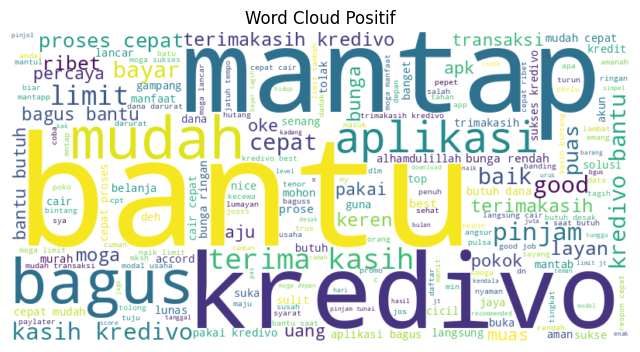

In [19]:
data_positif = data["Word Stem"].loc[data["Label"] == "positive"]
wordcloud_positif = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data_positif))
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(wordcloud_positif, interpolation='bilinear')
ax.axis('off')
plt.title('Word Cloud Positif')
plt.show()

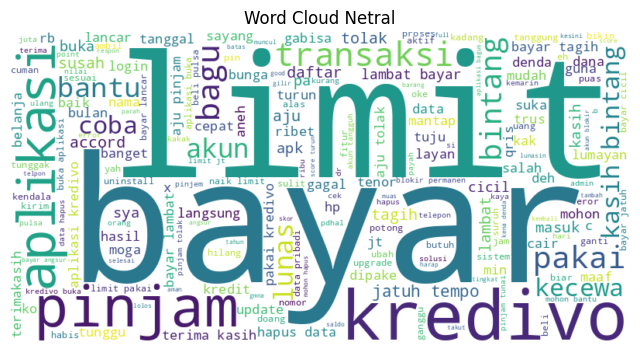

In [20]:
data_netral = data["Word Stem"].loc[data["Label"] == "neutral"]
wordcloud_netral = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data_netral))
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(wordcloud_netral, interpolation='bilinear')
ax.axis('off')
plt.title('Word Cloud Netral')
plt.show()

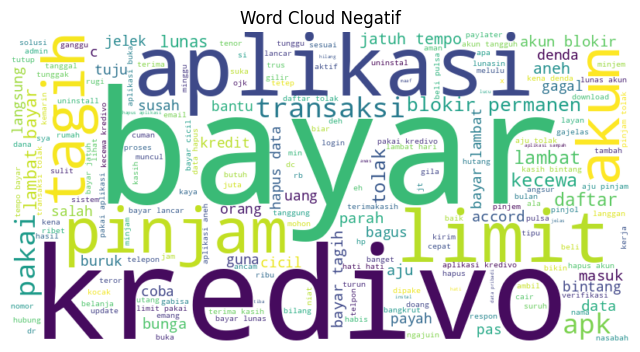

In [21]:
data_negatif = data["Word Stem"].loc[data["Label"] == "negative"]
wordcloud_negatif = WordCloud(width=800, height=400, background_color='white').generate(" ".join(data_negatif))
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(wordcloud_negatif, interpolation='bilinear')
ax.axis('off')
plt.title('Word Cloud Negatif')
plt.show()

### Membangun Model

In [ ]:
!pip install scikit-optimize
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from skopt import BayesSearchCV

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,3))

In [ ]:
x = tfidf.fit_transform(data["Word Stem"]).toarray()
y = data["Label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [ ]:
cls_svm = SVC()
cls_svm.fit(X_train, y_train)

SVC()

              precision    recall  f1-score   support

    negative       0.93      0.92      0.92      2388
     neutral       0.91      0.79      0.85      2414
    positive       0.82      0.94      0.88      2397

    accuracy                           0.88      7199
   macro avg       0.89      0.88      0.88      7199
weighted avg       0.89      0.88      0.88      7199



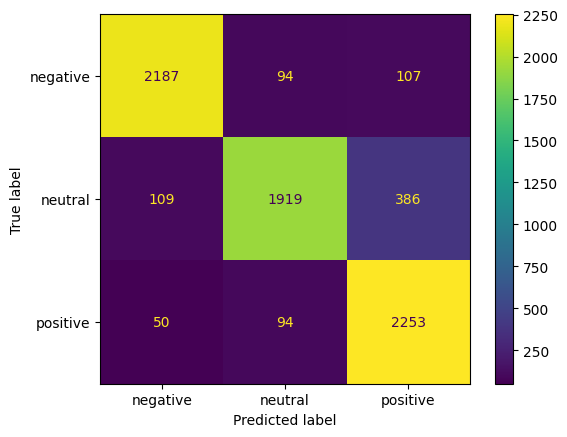

In [ ]:
print(classification_report(y_true=y_train, y_pred=cls_svm.predict(X_train)))
ConfusionMatrixDisplay.from_estimator(cls_svm, X_train, y_train)

              precision    recall  f1-score   support

    negative       0.71      0.70      0.70      1611
     neutral       0.60      0.55      0.57      1586
    positive       0.77      0.86      0.81      1603

    accuracy                           0.70      4800
   macro avg       0.69      0.70      0.70      4800
weighted avg       0.69      0.70      0.70      4800



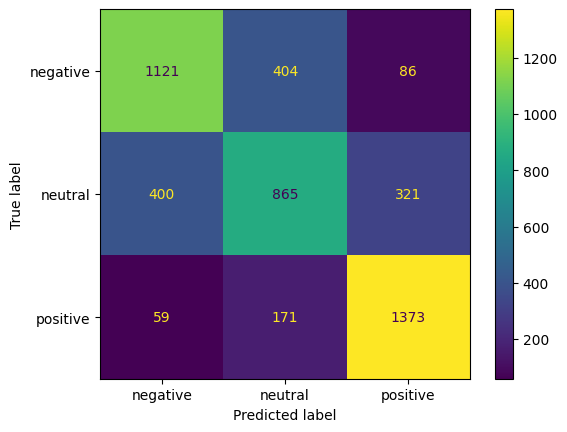

In [ ]:
print(classification_report(y_true=y_test, y_pred=cls_svm.predict(X_test)))
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=cls_svm.predict(X_test))

### Hyper Parameter Tuning + SMOTE

In [ ]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
params = {
    'C': [0.001, 0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

svm_bayes = BayesSearchCV(cls_svm, search_spaces=params, n_iter=5, n_jobs=-1, cv=3,random_state=42, verbose=2)

svm_bayes.fit(X_train, y_train)

# Model yang telah di tuning
best_svm_bayes = svm_bayes.best_estimator_

print(f"Bayes Search Best Combination for model SVM : {svm_bayes.best_params_}")

bayes_svm_train_score = best_svm_bayes.score(X_train, y_train)
print(f"SVM HyperParameter Tuned Train Score : {bayes_svm_train_score}")

bayes_svm_test_score = best_svm_bayes.score(X_test, y_test)
print(f"SVM HyperParameter Tuned Test Score : {bayes_svm_test_score}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bayes Search Best Combination for model SVM : OrderedDict([('C', 10), ('gamma', 10), ('kernel', 'rbf')])
SVM HyperParameter Tuned Train Score : 0.923916045291356
SVM HyperParameter Tuned Test Score : 0.5147916666666666


### Model LTSM dan Word Embedding menggunakan BERT

In [22]:
from transformers import BertTokenizer, BertModel
import torch

In [23]:
# kalimat yang akan di digunakan
texts = data["Text Cleaned"].to_list()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertModel.from_pretrained("indolem/indobert-base-uncased")
model.to(device)
model.eval()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("indolem/indobert-base-uncased")
def extract_features(texts, tokenizer, model, max_length=128):
    features = []
    count = 0
    for text in texts:
        encoded = tokenizer(
            text,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=max_length
        )
        # Kirim input ke GPU
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)

        sequence_output = outputs.last_hidden_state.squeeze(0).cpu().numpy()  # Balik ke CPU
        features.append(sequence_output)
        count += 1
        if count % 1000 == 0:
          print(f"Processed {count} texts")
          import gc
          torch.cuda.empty_cache()
          gc.collect()

    return np.array(features)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [24]:
# Ekstraksi fitur
features = extract_features(texts, tokenizer, model)
# Encoding Label
le = LabelEncoder()
y = le.fit_transform(data["Label"])

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Processed 1000 texts
Processed 2000 texts
Processed 3000 texts
Processed 4000 texts
Processed 5000 texts
Processed 6000 texts
Processed 7000 texts
Processed 8000 texts
Processed 9000 texts
Processed 10000 texts
Processed 11000 texts


In [26]:
features.shape

(11999, 128, 768)

In [ ]:
# Model LTSM
model = Sequential()
model.add(LSTM(128,input_shape=(128, 768),return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # Gunakan 'softmax' jika multiclass

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.4, random_state=42)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
test_model = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)